# <center>Trabajo Práctico N°1 : Reservas de Hotel</center>

**Grupo:** N°28 - The Kingdom

**Checkpoint N° 3**: Ensambles

**Alumnos**:


*   Jurgens, Cecilia Ines
*   Schipani, Martin Sebastian
*   Soto, Marylin Nicole

**Corrector:** Franco Mastelli

---


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection  import GridSearchCV, StratifiedKFold, KFold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
ds_hotel_test = pd.read_csv("hotels_test.csv")
df_hotel_test = ds_hotel_test.copy()
ds_hotel_train = pd.read_csv("hotels_train.csv")
df_hotel_train = ds_hotel_train.copy()

## Preprocesamiento de Datasets

Analizamos la cantidad de filas y columnas entre el dataset de train y de test:

In [ ]:
print("El dataset train tiene "f"{df_hotel_train.shape[0]}"" filas y "f"{df_hotel_train.shape[1]}"" columnas.")
print("El dataset test tiene "f"{df_hotel_test.shape[0]}"" filas y "f"{df_hotel_test.shape[1]}"" columnas.")

El dataset train tiene 61913 filas y 31 columnas.
El dataset test tiene 26535 filas y 31 columnas.


Determinamos que columnas faltan en cada dataset:

In [ ]:
columnas_faltantes_train = set(df_hotel_test.columns)-set(df_hotel_train.columns)
columnas_faltantes_test = set(df_hotel_train.columns) - set(df_hotel_test.columns)

print('Columnas faltantes en el dataset de Train: ', columnas_faltantes_train)
print('Columnas faltantes en el dataset de Test: ', columnas_faltantes_test)


Columnas faltantes en el dataset de Train:  {'reservation_status_date'}
Columnas faltantes en el dataset de Test:  {'is_canceled'}


### Dataset Train:

Aplicamos la limpieza que fue detallada en el checkpoint 2 en el dataset de train:

In [ ]:
#COUNTRY
##Reemplazamos los valores nulos con la moda
df_hotel_train.fillna({'country':-1}, inplace = True)
df_hotel_train.replace({-1, "PRT"})

country_top_train = df_hotel_train['country'].value_counts()
top_20_country_train = country_top_train.head(20).index.tolist()
df_hotel_train['country'] = df_hotel_train['country'].apply(lambda x: x if x in top_20_country_train else 'other')

#LEAD_TIME
##Tratamiento de outliers:
#df_hotel_train.drop(df_hotel_train[df_hotel_train['lead_time']>=500].index, axis='index', inplace=True)

#STAYS_IN_WEEK_NIGHTS
##Tratamiento de outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['stays_in_week_nights']>=25].index, axis='index', inplace=True)

#ADULTS
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['adults']==0].index, axis='index', inplace=True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['adults']>3].index, axis='index', inplace=True)

#CHILDREN
##Eliminacion de los registros con datos nulos de esta variable:
#df_hotel_train.drop(df_hotel_train[df_hotel_train['children'].isna() == True].index, axis='index', inplace=True)
df_hotel_train.fillna({'children':0}, inplace = True)
df_hotel_train['children'] = df_hotel_train['children'].astype(int)
df_hotel_train.loc[df_hotel_train['children'] < 0, 'children'] = 0
df_hotel_train.drop(df_hotel_train[df_hotel_train['children']>=10].index, axis = 'index', inplace = True)

##Tratiento de outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['children']>=10].index, axis='index', inplace=True)

#BABIES
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['babies']>=9].index, axis='index', inplace=True)

#PREVIOUS_CANCELLATIONS
##Tratamiento de Outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['previous_cancellations']>=2].index, axis='index', inplace=True)

#DAYS_IN_WAITING_LIST
##Tratamiento de outliers
#df_hotel_train.drop(df_hotel_train[df_hotel_train['days_in_waiting_list']>=200].index, axis='index', inplace=True)

#ADR
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['adr']<=0].index, axis='index', inplace=True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['adr']>=400].index, axis='index', inplace=True)
media_adr = np.mean(df_hotel_train.adr)
std_adr = np.std(df_hotel_train.adr)
df_hotel_train['z_adr'] = (df_hotel_train.adr-media_adr)/std_adr
df_hotel_train['z_adr'] = st.zscore(df_hotel_train.adr)
df_hotel_train.drop(df_hotel_train[df_hotel_train['z_adr'] > 3].index, axis = 'index', inplace = True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['z_adr'] < -2].index, axis = 'index', inplace = True)
df_hotel_train.drop(labels = 'z_adr', inplace = True, axis = 1)

#REQUIRED_CAR_PARKING_SPACES
##Tratamiento de outliers:
df_hotel_train.loc[(df_hotel_train['adults'] == 2) & (df_hotel_train['required_car_parking_spaces'] == 3), 'required_car_parking_spaces'] = 2
df_hotel_train.loc[(df_hotel_train['adults'] == 2) & (df_hotel_train['required_car_parking_spaces'] == 8), 'required_car_parking_spaces'] = 2

#TOTAL_OF_SPECIAL_REQUESTS
df_hotel_train.loc[(df_hotel_train['total_of_special_requests'] >= 4), 'total_of_special_requests'] = 1

#AGENT
#df_hotel_train.dropna(subset=['agent'], inplace = True)
df_hotel_train.fillna({'agent':-1}, inplace = True)
df_hotel_train['agent'] = df_hotel_train['agent'].astype(int)

#ASSIGNED ROOM TYPE
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'K') & (df_hotel_train['adr'] >160)].index, inplace = True)
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'I') & (df_hotel_train['adr'] >210)].index, inplace = True)
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'B') & (df_hotel_train['adr'] >160)].index, inplace = True)
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'B') & (df_hotel_train['adr'] <30)].index, inplace = True)

df_hotel_train.drop(df_hotel_train[(df_hotel_train['distribution_channel'] == 'Undefined')].index, inplace = True)

Convertimos los meses del año en numeros:

In [ ]:
meses_a_numeros ={
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July':7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df_hotel_train.arrival_date_month = df_hotel_train.arrival_date_month.map(meses_a_numeros)

Transformamos los datos de children en int:

In [ ]:
df_hotel_train['children'] = df_hotel_train['children'].astype(int)

Reemplazamos en meal todos aquellos que dicen undefined por SC (como es aclarado en el paper):

In [ ]:
df_hotel_train.loc[df_hotel_train.loc[:,'meal'] == 'Undefined','meal'] ='SC'

Convertimos las letras de habitaciones de los hoteles por numeros:

In [ ]:
dormitorio_letra_a_numero ={
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11
}
df_hotel_train.reserved_room_type = df_hotel_train.reserved_room_type.map(dormitorio_letra_a_numero)

Elimino todas aquellas columnas que no se necesitaran en la busqueda de arboles:

In [ ]:
columnas_eliminar =[ 'id', 'assigned_room_type', 'company']
df_hotel_train.drop(columnas_eliminar, axis='columns', inplace=True)

One hot encoding para variables categoricas:

In [ ]:
columnas_dummies = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
df_hotel_train = pd.get_dummies(df_hotel_train, columns= columnas_dummies, drop_first= True)

Verificamos que no nos queden valores nulos en el dataset train:

In [ ]:
df_hotel_train.isna().sum()

lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
is_canceled                       0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
country_BEL                       0
country_BRA                       0
country_CHE                 

### Dataset Test:

Analizamos los valores nulos del dataset:

In [ ]:
df_hotel_test.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


In [ ]:
#COUNTRY
##Reemplazamos los valores nulos con la moda
df_hotel_test.fillna({'country':-1}, inplace = True)
df_hotel_test.replace({-1, "PRT"})

#country_top_test = df_hotel_test['country'].value_counts()
#top_5_country_test = country_top_test.head(5).index.tolist()
df_hotel_test['country'] = df_hotel_test['country'].apply(lambda x: x if x in top_20_country_train else 'other')

#AGENT
df_hotel_test.fillna({'agent':-1}, inplace = True)

#CHILDREN
df_hotel_test.fillna({'children':0}, inplace = True)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)

#ADR
##Tratamiento de Outliers:
media_adr = np.mean(df_hotel_test.adr)
std_adr = np.std(df_hotel_test.adr)

#AGENT
#df_hotel_train.dropna(subset=['agent'], inplace = True)
df_hotel_train.fillna({'agent':-1}, inplace = True)
df_hotel_train['agent'] = df_hotel_train['agent'].astype(int)

df_hotel_test.loc[df_hotel_test.loc[:,'meal'] == 'Undefined','meal'] ='SC'

In [ ]:
columnas_eliminar_test = ['id', 'assigned_room_type', 'company', 'reservation_status_date' ]
df_hotel_test.drop(columnas_eliminar_test, axis='columns', inplace= True)

Convertimos los meses del año en numeros:

In [ ]:
meses_a_numeros_test ={
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July':7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df_hotel_test.arrival_date_month = df_hotel_test.arrival_date_month.map(meses_a_numeros_test)

Convertimos las letras de habitaciones de los hoteles por numeros:

In [ ]:
dormitorio_letra_a_numero_test ={
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11,
    'P': 12
}
df_hotel_test.reserved_room_type = df_hotel_test.reserved_room_type.map(dormitorio_letra_a_numero_test)

One hot Encoding para variables categoricas:

In [ ]:
columnas_dummies_test = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
df_hotel_test = pd.get_dummies(df_hotel_test, columns = columnas_dummies_test, drop_first= True)

Verificamos que no nos queden valores nulos en el dataset test:

In [ ]:
df_hotel_test.isna().sum()

lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
country_BEL                       0
country_BRA                       0
country_CHE                       0
country_CHN                 

## A. Clasificador K-Nearest Neighbors

### Entrenamiento

In [ ]:
df_hotel_train_x = df_hotel_train.drop(['is_canceled'], axis = 'columns', inplace = False)
df_hotel_train_y = df_hotel_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_hotel_train_x,
                                                    df_hotel_train_y,
                                                    test_size= 0.15,
                                                    random_state = 28)


### Modelo Sin Optimizar

Creamos un modelo con sus parametros por defecto:

In [ ]:
KNN_Classifier = KNeighborsClassifier()

KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
KNN_Classifier.fit(x_train, y_train)
y_pred = KNN_Classifier.predict(x_test)

In [ ]:
print('CORRECTAS: ', np.sum(y_test == y_pred))
print('TOTAL: ', len(y_test))

CORRECTAS:  6611
TOTAL:  8944


In [ ]:
f1_score(y_test, y_pred)

0.7402872091728823

In [ ]:
y_pred = KNN_Classifier.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred})

In [ ]:
#df_summision.to_csv('summit1.csv', index = False)

Analizamos el modelo de KNN variando la cantidad de vecinos:

In [ ]:
metrics = []
k_range = range(1, 100)
for n in k_range:
  knn = KNeighborsClassifier(n_neighbors = n)
  knn.fit(x_train, y_train)
  y_pred_2 = knn.predict(x_test)
  metrics.append((n, (y_test == y_pred_2).sum()))

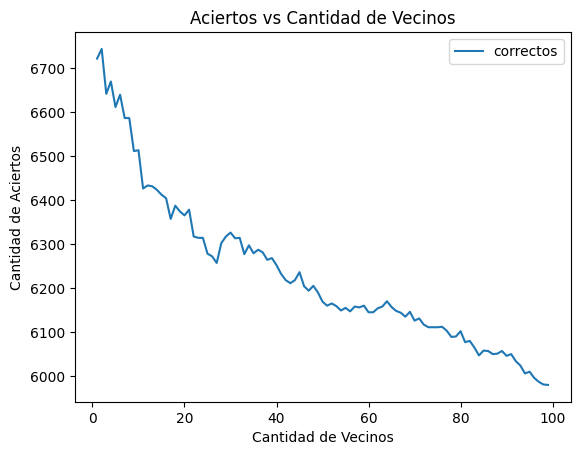

In [ ]:
df_metrics = pd.DataFrame(metrics, columns = ['cant_vecinos', 'correctos'])
ax = df_metrics.plot(x = 'cant_vecinos',
                     y = 'correctos',
                     title = 'Aciertos vs Cantidad de Vecinos')
ax.set_xlabel('Cantidad de Vecinos')
ax.set_ylabel('Cantidad de Aciertos')
plt.show()

Vemos que a medida que aumenta la cantidad de vecinos, disminuye la cantidad de aciertos.

In [ ]:
k_range = range(1, 50)
k_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'f1')
  k_scores.append(scores.mean())

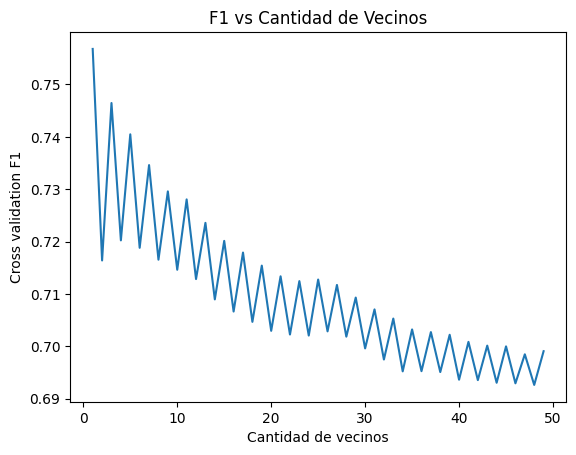

In [ ]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Cross validation F1')
plt.title('F1 vs Cantidad de Vecinos')
plt.show()

### Optimizacion con hiperparametros

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_test_minmax = min_max_scaler.transform(x_test)

stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

#### MinMax Scaler

In [ ]:
params_grid = {
    'n_neighbors' : range(1,15),
    'weights' : ['distance', 'uniform'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'metric' : ['euclidean', 'manhattan', 'chebyshev']
}

knn = KNeighborsClassifier()
rand = RandomizedSearchCV(knn, params_grid, cv = 10, scoring = 'f1', n_iter = 10, random_state = 28)
rand.fit(x_train_minmax, y_train)
rand.cv_results_['mean_test_score']

array([0.79270522, 0.78923356, 0.83368791, 0.82410496, 0.81919932,
       0.83241064, 0.82102981, 0.83319805, 0.82275744, 0.81177129])

In [ ]:
print("Mejores hiperparametros encontrados: ", rand.best_params_)
print(rand.best_score_)

Mejores hiperparametros encontrados:  {'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
0.8336879097608332


In [ ]:
y_pred = rand.predict(x_test_minmax)

##### Matriz de Confusion

Text(50.722222222222214, 0.5, 'True')

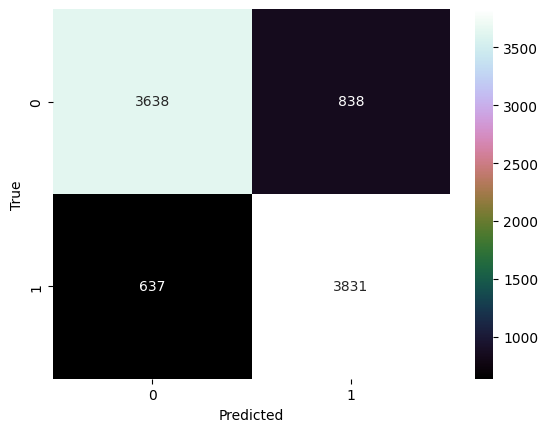

In [ ]:
matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, cmap = 'cubehelix', annot = True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4476
           1       0.82      0.86      0.84      4468

    accuracy                           0.84      8944
   macro avg       0.84      0.84      0.84      8944
weighted avg       0.84      0.84      0.84      8944



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("F1-Score: " + str(f1))
print("Precision: " + str(precision))

Accuracy: 0.8350849731663685
Recall: 0.8574306177260519
F1-Score: 0.838568457918354
Precision: 0.8205183122724352


##### Guardar Prediccion

In [ ]:
y_pred_t = rand.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_t})

In [ ]:
df_summision.to_csv('summit_knn_minmax.csv', index = False)

#### Norm-scaler

In [ ]:
params_grid = {
    'n_neighbors' : range(1,15),
    'weights' : ['distance', 'uniform'],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'metric' : ['euclidean', 'manhattan', 'chebyshev']
}

knn = KNeighborsClassifier()
rand = RandomizedSearchCV(knn, params_grid, cv = 10, scoring = 'f1', n_iter = 10, random_state = 28)
rand.fit(x_train_norm, y_train)
rand.cv_results_['mean_test_score']

array([0.78912316, 0.78913428, 0.83389018, 0.82301237, 0.81859773,
       0.83130569, 0.81595327, 0.83327779, 0.82220104, 0.81037167])

In [ ]:
print("Mejores hiperparametros encontrados: ", rand.best_params_)
print("Mejor F1-Score: ", rand.best_score_)

Mejores hiperparametros encontrados:  {'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean', 'algorithm': 'kd_tree'}
Mejor F1-Score:  0.8338901836520982


In [ ]:
knn_norm = KNeighborsClassifier(**rand.best_params_)
knn_norm.fit(x_train_norm, y_train)
y_pred_knn_norm = knn_norm.predict(x_test_norm)

In [ ]:
import joblib
joblib.dump(knn_norm, 'kkn_norm.joblib')

['kkn_norm.joblib']

##### Matriz de Confusion

Text(50.722222222222214, 0.5, 'True')

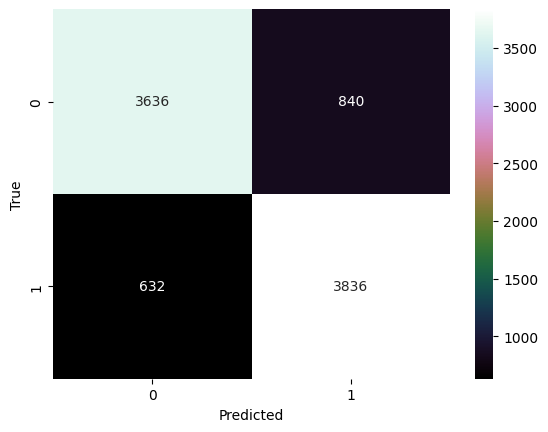

In [ ]:
matriz = confusion_matrix(y_test, y_pred_knn_norm)
sns.heatmap(matriz, cmap = 'cubehelix', annot = True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
print(classification_report(y_test,y_pred_knn_norm))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4476
           1       0.82      0.86      0.84      4468

    accuracy                           0.84      8944
   macro avg       0.84      0.84      0.84      8944
weighted avg       0.84      0.84      0.84      8944



##### Guardar Prediccion

In [ ]:
y_pred_t = rand.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_t})

In [ ]:
df_summision.to_csv('summit_knn_norm.csv', index = False)